In [1]:
import sys 
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from scipy.fftpack import fftn, ifftn, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
from database import Magneticum

In [4]:
dataframe_clu = Magneticum('022','b','cluster').dataframe


In [5]:
dataframe_gal = Magneticum('022','b','galaxies').dataframe

In [16]:
df1 = pd.DataFrame.from_dict(
                            {'x':dataframe_clu['x[kpc/h]']/0.7,
                            'y':dataframe_clu['y[kpc/h]']/0.7,
                            'z':dataframe_clu['z[kpc/h]']/0.7,
                            'vx':dataframe_clu['vx[km/s]'],
                            'vy':dataframe_clu['vy[km/s]'],
                            'vz':dataframe_clu['vz[km/s]'],
                            }   
                            )

In [17]:
df2 = pd.DataFrame.from_dict(
                            {'x':dataframe_gal['x[kpc/h]']/0.7,
                            'y':dataframe_gal['y[kpc/h]']/0.7,
                            'z':dataframe_gal['z[kpc/h]']/0.7,
                            }
                            )

In [45]:
from sklearn.model_selection import train_test_split

df_clu, _ = train_test_split(df1, test_size=.983, random_state=42)


In [46]:
print(len(df1),len(df_clu),len(df1)/len(df_clu))

42028 714 58.86274509803921


In [47]:
df_gal = df2.copy()

In [48]:
from scipy.spatial import KDTree


df_clu[['x', 'y', 'z']] /= 1000  
df_gal[['x', 'y', 'z']] /= 1000


tree = KDTree(df_gal[['x', 'y', 'z']])

# Finding galaxies within a 10 Mpc radius
density = []
for index, row in df_clu.iterrows():
    density.append(len(tree.query_ball_point([row['x'], row['y'], row['z']], 10)))

# Normalize the density
mean_density = np.mean(density)
density = (density - mean_density) / mean_density
df_clu['density'] = density

In [51]:
L_x = df1['x'].max() - df1['x'].min()
L_y = df1['y'].max() - df1['y'].min()
L_z = df1['z'].max() - df_clu['z'].min()

# The box length L is the maximum extent in either x, y, or z direction
L = max(L_x, L_y, L_z)

In [52]:
L/=1000

In [53]:
from numpy.fft import fftn, ifftn, fftfreq
from scipy.interpolate import RegularGridInterpolator

N = len(df_clu)  # Number of grid points
grid_side_length = N # for a 128x128x128 grid. Adjust as needed.
grid_edges = np.linspace(0, L, grid_side_length + 1)

# Calculate the 3D histogram
density_field, edges = np.histogramdd(df_clu[['x', 'y', 'z']].values, bins=[grid_edges, grid_edges, grid_edges], weights=df_clu['density'])

# Now you can perform the FFT on the 3D density field
density_ft = fftn(density_field)
print(density_ft.shape)
# Getting the wave vectors
freq = fftfreq(N, d=L/N)
kx, ky, kz = np.meshgrid(freq, freq, freq, indexing='ij')
print(kx.shape)

k_squared = kx**2 + ky**2 + kz**2
k_squared[0, 0, 0] = 1

# Calculating the momentum field (ignoring the factor of -i)
momentum_x = density_ft * kx / k_squared
momentum_y = density_ft * ky / k_squared
momentum_z = density_ft * kz / k_squared

# Inverse Fourier Transform to get velocity field
velocity_x = np.real(ifftn(momentum_x))
velocity_y = np.real(ifftn(momentum_y))
velocity_z = np.real(ifftn(momentum_z))

velocity_x_interpolator = RegularGridInterpolator((grid_edges[:-1], grid_edges[:-1], grid_edges[:-1]), velocity_x, bounds_error=False, fill_value=None)
velocity_y_interpolator = RegularGridInterpolator((grid_edges[:-1], grid_edges[:-1], grid_edges[:-1]), velocity_y, bounds_error=False, fill_value=None)
velocity_z_interpolator = RegularGridInterpolator((grid_edges[:-1], grid_edges[:-1], grid_edges[:-1]), velocity_z, bounds_error=False, fill_value=None)

# Interpolating the velocities at the positions of the halos
df_clu['Vx'] = velocity_x_interpolator(df_clu[['x', 'y', 'z']].values)
df_clu['Vy'] = velocity_y_interpolator(df_clu[['x', 'y', 'z']].values)
df_clu['Vz'] = velocity_z_interpolator(df_clu[['x', 'y', 'z']].values)



(714, 714, 714)
(714, 714, 714)


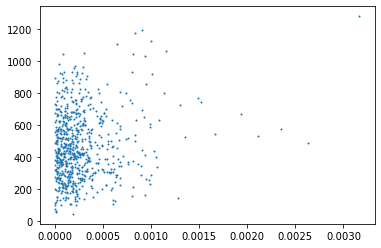

In [54]:
plt.scatter(np.sqrt(df_clu['Vx']**2 + df_clu['Vy']**2 + df_clu['Vz']**2),np.sqrt(df_clu['vx']**2 + df_clu['vy']**2 + df_clu['vz']**2),s=1)

In [55]:
np.corrcoef(np.sqrt(df_clu['Vx']**2 + df_clu['Vy']**2 + df_clu['Vz']**2),np.sqrt(df_clu['vx']**2 + df_clu['vy']**2 + df_clu['vz']**2),)

array([[1.        , 0.16789734],
       [0.16789734, 1.        ]])